In [2]:

import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
from shapely.ops import unary_union
import numpy as np
import matplotlib.patches as mpatches


In [3]:
lor_shp = gpd.read_file("/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/DEU Housing Project/data/raw/lor_planungsraeume_2021.shp/lor_planungsraeume_2021.shp")
lor_shp = lor_shp.set_geometry('geometry')
lor_shp = lor_shp[['PLR_ID', 'geometry' ]]

sbahn_ring_poly = gpd.read_file("/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/DEU Housing Project/data/raw/sbahn_ring/sbahn_ring_poly.shp")
sbahn_ring_poly = sbahn_ring_poly.set_geometry('geometry')
sbahn_ring_poly = sbahn_ring_poly[['sring', 'geometry' ]]

auto_ring_poly = gpd.read_file("/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/DEU Housing Project/data/raw/autobahn_ring/autobahn_ring_poly.shp")
auto_ring_poly = auto_ring_poly.set_geometry('geometry')
auto_ring_poly = auto_ring_poly[['auto_ring', 'geometry' ]]

dataframe2 = pd.read_stata("/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/DEU Housing Project/data/temp/socialhousing_onlytreated.dta")
dataframe3 = pd.read_stata("/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/DEU Housing Project/data/temp/socialhousing_onlydonors.dta")


In [4]:
# Merging the two data frames 
df_treated = pd.merge(lor_shp, dataframe2)
df_control = pd.merge(lor_shp, dataframe3)
len(df_treated)
len(df_control)

304

In [5]:
# Set the CRS manually (example using EPSG:3857)
sbahn_ring_poly = sbahn_ring_poly.set_crs(3857, allow_override=True)
print("Sbahn CRS:", sbahn_ring_poly.crs)

# Ensure both GeoDataFrames have the same CRS
target_crs = sbahn_ring_poly.crs
lor_shp = lor_shp.to_crs(target_crs)
auto_ring_poly = auto_ring_poly.to_crs(target_crs)
df_treated = df_treated.to_crs(target_crs)
df_control = df_control.to_crs(target_crs)

# Calculate the area
lor_shp['area'] = lor_shp.geometry.area

Sbahn CRS: EPSG:3857


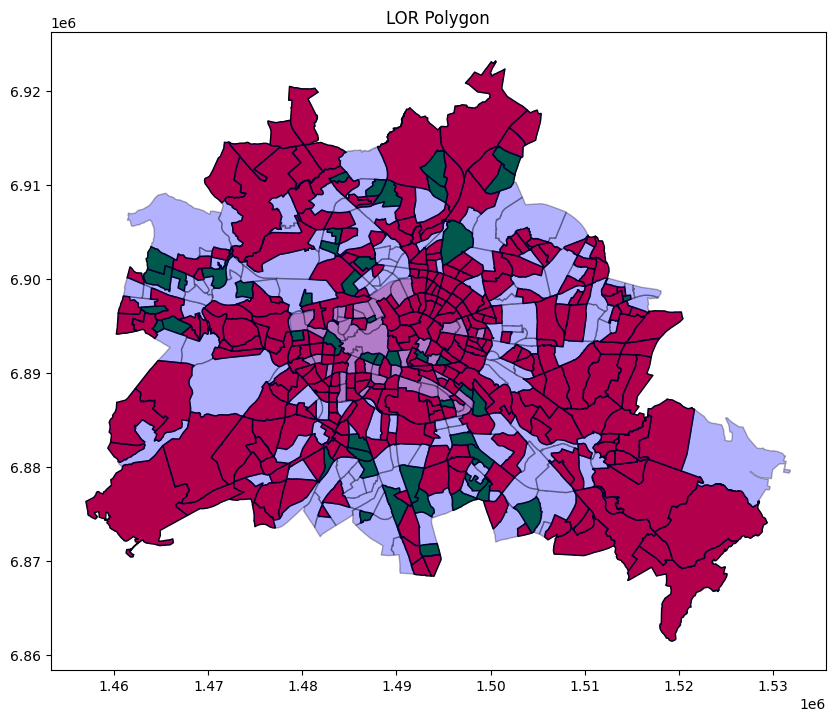

In [6]:
# Plot the LOR shapefile separately
fig, ax = plt.subplots(figsize=(10, 10))
sbahn_ring_poly.plot(ax=ax, color='red', edgecolor='black', alpha=0.3, label='S-Bahn Ring')
# Note that there are two versions of the treatment 1. more than 5% loss (Variable: treated1) and 2. more than 3% loss (Variable: treated_2) in social housing units
df_treated[df_treated['treated1'] == 1].plot(ax=ax, color='green', edgecolor='black', alpha=1, label='Treat')
df_control.plot(ax=ax, color='red', edgecolor='black', alpha=1, label='Treat')
lor_shp.plot(ax=ax, color='blue', edgecolor='black', alpha=0.3, label='LOR')
plt.title('LOR Polygon')
plt.show()

In [7]:
# Perform spatial intersection
intersection_gdf = gpd.overlay(lor_shp, sbahn_ring_poly, how='union')
print("Variable names in merged_gdf:", intersection_gdf.columns)

# Calculate the area aftre splitting
intersection_gdf['area_split'] = intersection_gdf.geometry.area

# Calculate area share
intersection_gdf['area_share'] = intersection_gdf['area_split'] / intersection_gdf['area']

# Filter the dataframe
intersection_gdf = intersection_gdf.replace([np.nan, -np.inf], 0)

filtered_gdf = intersection_gdf[(intersection_gdf['sring'] == 1)  & (intersection_gdf['area_share'] > 0.40)]

# Print the full variable names and PLR_ID
print(filtered_gdf[['PLR_ID', 'sring']])

Variable names in merged_gdf: Index(['PLR_ID', 'area', 'sring', 'geometry'], dtype='object')
       PLR_ID  sring
0    02500831    1.0
1    07100103    1.0
2    02300315    1.0
4    02500832    1.0
5    02100104    1.0
..        ...    ...
151  02200208    1.0
152  01100311    1.0
153  04501042    1.0
154  01100101    1.0
155  08100101    1.0

[145 rows x 2 columns]


In [8]:
# Perform spatial intersection
inter_auto_gdf = gpd.overlay(lor_shp, auto_ring_poly, how='union')
print("Variable names in merged_gdf:", inter_auto_gdf.columns)

# Calculate the area aftre splitting
inter_auto_gdf['area_split'] = inter_auto_gdf.geometry.area

# Calculate area share
inter_auto_gdf['area_share'] = inter_auto_gdf['area_split'] / inter_auto_gdf['area']

# Filter the dataframe
inter_auto_gdf = inter_auto_gdf.replace([np.nan, -np.inf], 0)

auto_filtered_gdf = inter_auto_gdf[(inter_auto_gdf['auto_ring'] == 1)  & (inter_auto_gdf['area_share'] > 0.40)]

# Print the full variable names and PLR_ID
print(auto_filtered_gdf[['PLR_ID', 'auto_ring']])

Variable names in merged_gdf: Index(['PLR_ID', 'area', 'auto_ring', 'geometry'], dtype='object')
       PLR_ID  auto_ring
0    02500831        1.0
1    07200412        1.0
2    07100103        1.0
3    02300315        1.0
4    03601245        1.0
..        ...        ...
185  01100311        1.0
186  04501042        1.0
187  01100101        1.0
188  01401048        1.0
189  08100101        1.0

[166 rows x 2 columns]


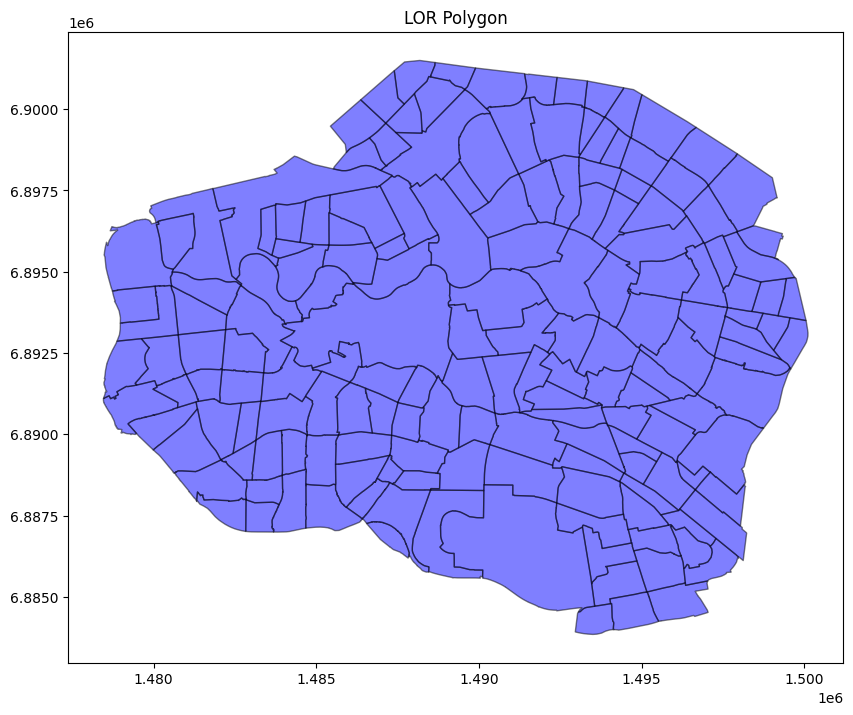

In [29]:
# Plot the LOR shapefile separately
fig, ax = plt.subplots(figsize=(10, 10))
auto_filtered_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5, label='LOR')
plt.title('LOR Polygon')
plt.show()

In [9]:
# Prepare visualization of treated and untreated within and outside A100
# Generate the 'treated' column in df_treated
# df_treated['treated'] = 1
df_control['treated'] = 0
df_treated['treated'] = 1
df_control['treated_2'] = 0

# Vertically concatenate df_treated and df_control
treatment = pd.concat([df_treated[df_treated['treated1'] == 1][['PLR_ID', 'treated']], df_control[['PLR_ID', 'treated']]], axis=0, ignore_index=True)

treatment_2 = pd.concat([df_treated[['PLR_ID', 'treated_2']], df_control[['PLR_ID', 'treated_2']]], axis=0, ignore_index=True)

within_a100 = auto_filtered_gdf.merge(
    treatment,  # Keep only 'PLR_ID' and 'treated' columns
    on='PLR_ID', 
    how='left'
)

within_2_a100 = auto_filtered_gdf.merge(
    treatment_2,  # Keep only 'PLR_ID' and 'treated' columns
    on='PLR_ID', 
    how='left'
)

# Perform the left join, keeping the geometry of lor_shp and merging with auto_filtered_gdf
outside_a100 = lor_shp.merge(
    auto_filtered_gdf[['PLR_ID']],  # Merge only on the 'PLR_ID' column
    on='PLR_ID', 
    how='left',  # Left join to keep all records from lor_shp
    indicator=True  # Adds a column '_merge' to indicate the merge status
)

# Keep only rows where the merge was not successful (indicator is 'left_only')
outside_a100 = outside_a100[outside_a100['_merge'] == 'left_only']

# merge periphery lors with treatment status information for first treatment (more than 5% SH)
outside_a100 = outside_a100.merge(
    treatment,  # Keep only 'PLR_ID' and 'treated' columns
    on='PLR_ID', 
    how='left'
)

# merge periphery lors with treatment status information for second treatment (more than 3% SH)
outside_2_a100 = outside_a100.merge(
    treatment_2,  # Keep only 'PLR_ID' and 'treated' columns
    on='PLR_ID', 
    how='left'
)

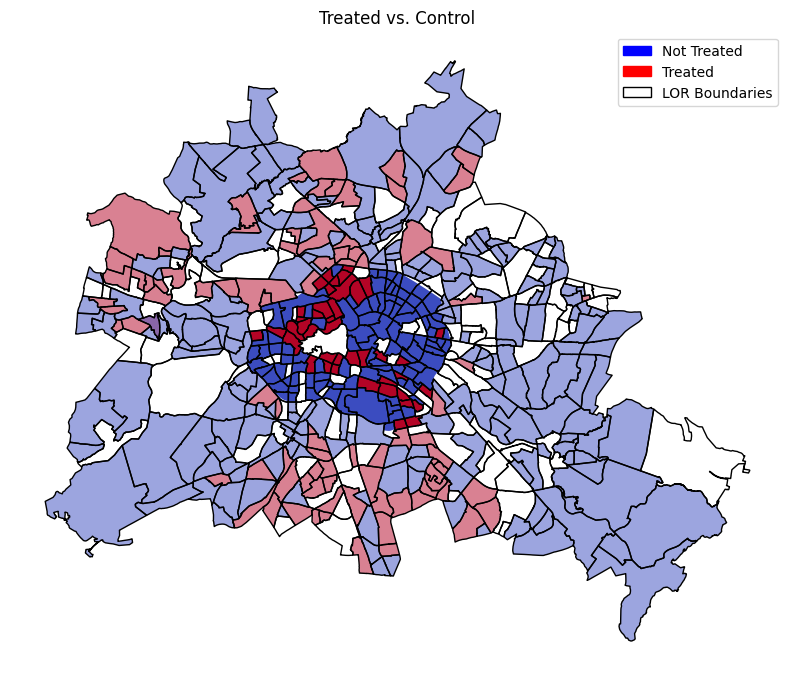

In [13]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot within_a100
within_2_a100.plot(column='treated_2', cmap='coolwarm', legend=False, ax=ax, alpha=1)

# Plot outside_a100
outside_2_a100.plot(column='treated_2', cmap='coolwarm', legend=False, ax=ax, alpha=0.5)

# Plot LOR boundaries with no fill, just the boundaries
lor_shp.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='LOR Boundaries')

# Create a categorical legend
treated_patch = mpatches.Patch(color='blue', label='Not Treated')
not_treated_patch = mpatches.Patch(color='red', label='Treated')
lor_patch = mpatches.Patch(color='black', label='LOR Boundaries', fill=False)

# Add the legend to the plot
ax.legend(handles=[treated_patch, not_treated_patch, lor_patch], loc='upper right')

# Set title and remove axis
ax.set_title("Treated vs. Control")
ax.axis('off')

# Save the plot as a JPEG file
# plt.savefig('/Users/maxmonert/Desktop/Research/Projects/SocialHousing/map_treat_2.jpeg', format='jpeg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [32]:
# Drop the geometry column
filtered_df = filtered_gdf[['PLR_ID', 'sring']]
auto_filtered_gdf = auto_filtered_gdf[['PLR_ID', 'auto_ring']]

# Convert to a pandas DataFrame
filtered_df = pd.DataFrame(filtered_df)
auto_filtered_gdf = pd.DataFrame(auto_filtered_gdf)

print(filtered_df)
# Save the final dataframe as a .dta file
filtered_df.to_stata('/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/DEU Housing Project/data/temp/sbahnring_lor.dta')
auto_filtered_gdf.to_stata('/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/DEU Housing Project/data/temp/autoring_lor.dta')


       PLR_ID  sring
0    02500831    1.0
1    07100103    1.0
2    02300315    1.0
4    02500832    1.0
5    02100104    1.0
..        ...    ...
151  02200208    1.0
152  01100311    1.0
153  04501042    1.0
154  01100101    1.0
155  08100101    1.0

[145 rows x 2 columns]


OSError: Cannot save file into a non-existent directory: '/Users/maxmonert/Library/CloudStorage/Dropbox/Projects/Housing Project/data/temp'